In [1]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import matplotlib.pyplot as plt

In [2]:
deliveries = pd.read_csv('deliveries.csv')

In [3]:
df = deliveries.copy()

In [4]:
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [5]:
def is_bowlers_wicket(player_dismissed, dismissal_kind):
    if type(player_dismissed) == str:
        if dismissal_kind not in [ 'run out', 'retired hurt', 'obstructing the field']:
            return 1
        else:
            return 0
    else:
        return 0

In [6]:
df['isBowlerWk'] = df.apply(lambda x: is_bowlers_wicket(x['player_dismissed'], x['dismissal_kind']), axis = 1)

In [7]:
def bowlerStats(df, current_innings):
    
    df = df[df.inning == current_innings]
    df.reset_index(inplace = True, drop = True)

    df['isDot'] = df['total_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['total_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['total_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['total_runs'].apply(lambda x: 1 if x == 3 else 0)

    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

    runs = pd.DataFrame(df.groupby(['bowler'])['total_runs'].sum()).reset_index().rename(columns = {'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})

    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})

    df = pd.merge(innings, balls, on = 'bowler').merge(runs, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler')
    
    df['dot%'] = df.apply(lambda x: 100*(x['dots']/x['balls']), axis = 1)
    
    return df

In [8]:
# dot% vs no_of_dismissals in ing 1/2

In [9]:
df1 = bowlerStats(df, 1)

In [10]:
df2 = bowlerStats(df, 2)

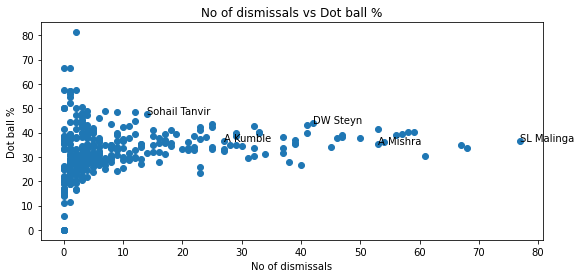

In [11]:
plt.figure(figsize = (9, 4))

plt.scatter(df1['dismissals'], df1['dot%'])
plt.xlabel('No of dismissals')
plt.ylabel('Dot ball %')
plt.title('No of dismissals vs Dot ball %')

selected_bowlers = ['A Kumble', 'SL Malinga', 'A Mishra', 'DW Steyn', 'Sohail Tanvir']
annotations = list(df1['bowler'])

for i, j in enumerate(annotations):
    if j in selected_bowlers:
        plt.annotate(j, (df1['dismissals'][i], df1['dot%'][i]))

plt.show()

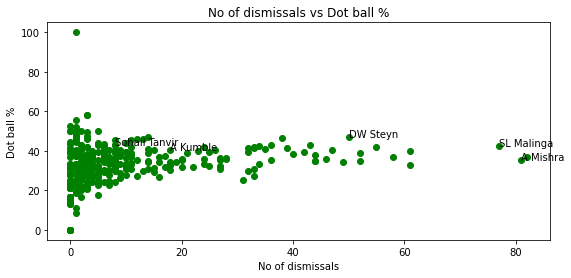

In [12]:
plt.figure(figsize = (9, 4))

plt.scatter(df2['dismissals'], df2['dot%'], color = 'g')
plt.xlabel('No of dismissals')
plt.ylabel('Dot ball %')
plt.title('No of dismissals vs Dot ball %')

selected_bowlers = ['A Kumble', 'SL Malinga', 'A Mishra', 'DW Steyn', 'Sohail Tanvir']
annotations = list(df2['bowler'])

for i, j in enumerate(annotations):
    if j in selected_bowlers:
        plt.annotate(j, (df2['dismissals'][i], df2['dot%'][i]))

plt.show()

In [13]:
df1['dot%'].mean(), df2['dot%'].mean()

(32.87034761618632, 32.693540117484446)

In [14]:
# use case 2: Bowler against all oppositions

In [15]:
def show_player(selected_player):
    
    total_wickets = df[df.bowler == selected_player].groupby(['bowler'])['isBowlerWk'].sum().item()

    plt.figure(figsize = (12, 4))

    df[df.bowler == selected_player].groupby(['batting_team'])['isBowlerWk'].sum().sort_values(ascending = True).plot(kind = 'barh', color = 'g')
    plt.title(selected_player + " - against all oppositions" + " (Wks :" + str(total_wickets) + ")")
    plt.xlabel('No of wickets')
    plt.ylabel('Opposition Teams')
    plt.show()

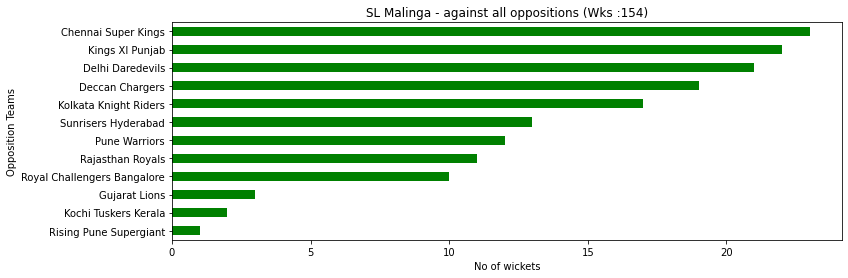

In [16]:
show_player('SL Malinga')

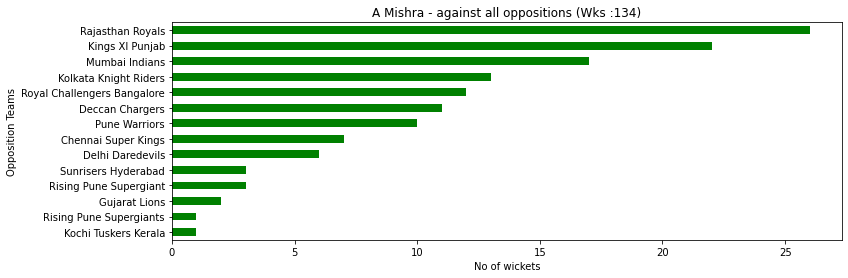

In [17]:
show_player('A Mishra')

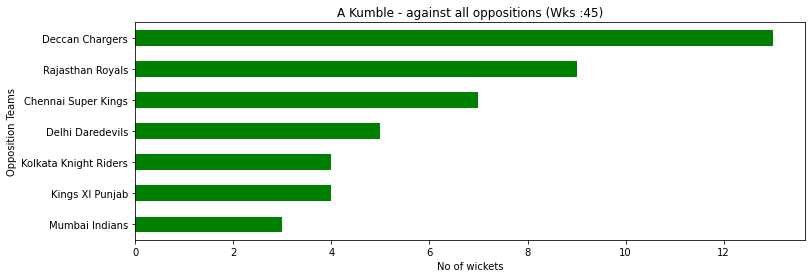

In [18]:
show_player('A Kumble')

## Toss Analysis & Venue Analysis:

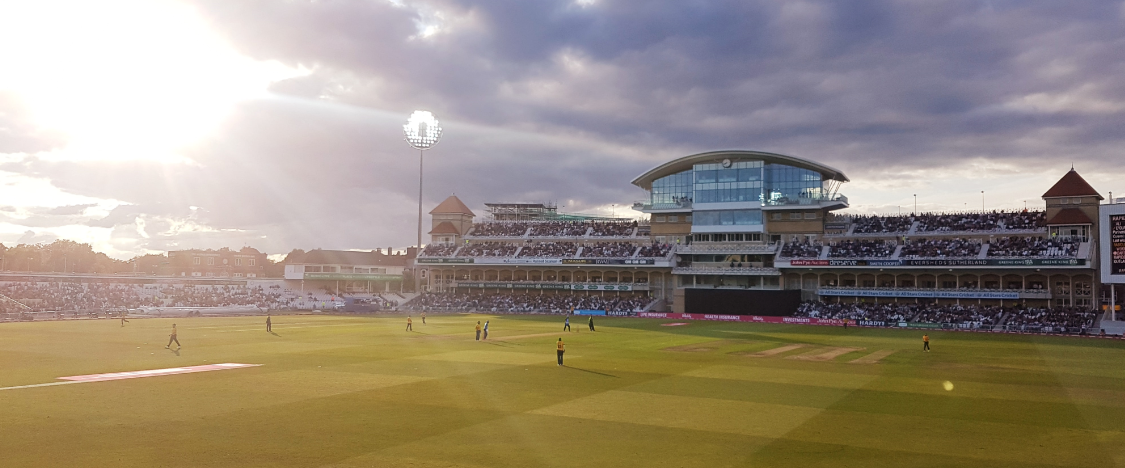

In [19]:
# use case: win toss & win match?

In [20]:
matches = pd.read_csv('matches.csv')

In [21]:
matches.head(1)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN


In [22]:
mdf = matches.copy()

In [23]:
mdf.columns

Index(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')

In [24]:
# team1, team2, winner, toss_winner, toss_decision

In [25]:
def wintoss_winmatch(toss_winner, winner):
    if toss_winner == winner:
        return 1
    else:
        return 0

In [26]:
mdf['wintoss_winmatch'] = mdf.apply(lambda x: wintoss_winmatch(x['toss_winner'], x['winner']), axis = 1)

In [27]:
mdf[['winner', 'toss_winner', 'wintoss_winmatch']].head()

,winner,toss_winner,wintoss_winmatch
0,Sunrisers Hyderabad,Royal Challengers Bangalore,0
1,Rising Pune Supergiant,Rising Pune Supergiant,1
2,Kolkata Knight Riders,Kolkata Knight Riders,1
3,Kings XI Punjab,Kings XI Punjab,1
4,Royal Challengers Bangalore,Royal Challengers Bangalore,1


In [28]:
len(mdf)

636

In [29]:
100*len(mdf[mdf.wintoss_winmatch == 1])/len(mdf)

51.100628930817614

In [30]:
pd.DataFrame(mdf.groupby('season')['wintoss_winmatch'].sum()/mdf.groupby('season')['wintoss_winmatch'].count())

,wintoss_winmatch
season,
2008,0.482759
2009,0.578947
2010,0.516667
2011,0.520548
2012,0.445946
2013,0.473684
2014,0.500000
2015,0.474576
2016,0.566667


In [31]:
mdf.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,wintoss_winmatch
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,0
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1


In [32]:
# venue = avg runs 

In [33]:
df.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0


In [34]:
mdf = mdf.rename(columns = {'id':'match_id'})

In [35]:
mdf.head(2)

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,wintoss_winmatch
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,0
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1


In [36]:
cdf = pd.merge(df, mdf, on = 'match_id', how = 'left')

In [37]:
cdf.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,wintoss_winmatch
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,0


In [38]:
vdf = pd.DataFrame(cdf.groupby(['venue'])['total_runs'].sum()/(cdf.groupby(['venue'])['match_id'].apply( lambda x: len(list(np.unique(x))))*2))

In [39]:
vdf.columns = ['avg_runs']

In [40]:
vdf.sort_values('avg_runs', ascending = False).head(5)

,avg_runs
venue,
Brabourne Stadium,174.636364
Saurashtra Cricket Association Stadium,166.650000
Barabati Stadium,162.714286
Green Park,162.250000
"Punjab Cricket Association IS Bindra Stadium, Mohali",161.136364


### Ideas for venue analysis:
- Avg runs in 1st/2nd
- Avg winning score
- Avg RPW
- Avg scoring rate - RR

## Problem Statement:

### What is the optimal bowling strategy in Chinnaswamy, Which type of bowlers to use & when (phase of play)?

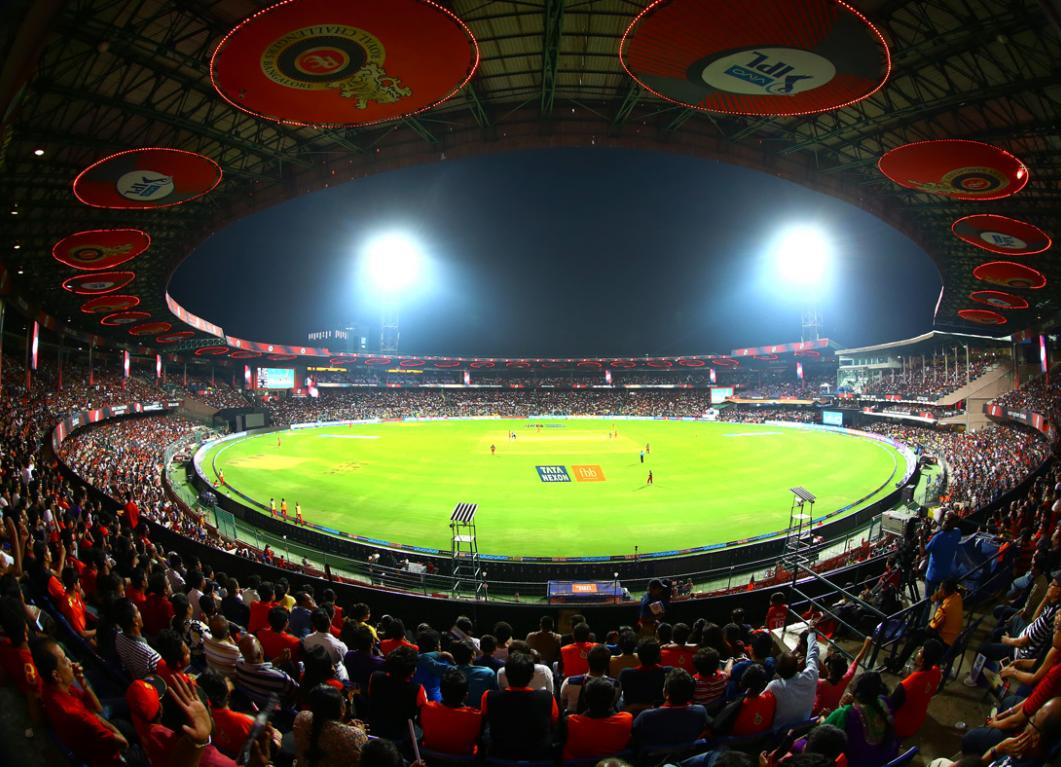

In [41]:
# data preparation # applying math to that data

In [42]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
#         return math.inf
        return balls/1
    
def runs_per_ball(runs_conceeded, balls):
    if balls > 0:
        return runs_conceeded/balls
    else:
        return 1000
    
def runs_per_dismissal(runs_conceeded, dismissals):
    if dismissals > 0:
        return runs_conceeded/dismissals
    elif (runs_conceeded == 0):
        return 1000
    else:
        return runs_conceeded/1

In [43]:
def ByCustom(df, current_phase, current_venue):
    
    df = df[df.phase == current_phase]
    df = df[df.venue == current_venue]
    df.reset_index(inplace = True, drop = True)

    df['isDot'] = df['total_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['total_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['total_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['total_runs'].apply(lambda x: 1 if x == 3 else 0)

    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

    runs = pd.DataFrame(df.groupby(['bowler'])['total_runs'].sum()).reset_index().rename(columns = {'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})

    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})

    df = pd.merge(innings, balls, on = 'bowler').merge(runs, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler')
    
    df['dot%'] = df.apply(lambda x: 100*(x['dots']/x['balls']), axis = 1)
    
    # balls_per_dismissal, runs_per_ball, runs_per_dismissal
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)
    df['Eco'] = df.apply(lambda x: 6*runs_per_ball(x['runs'], x['balls']), axis = 1)
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    return df

In [44]:
cdf.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,wintoss_winmatch
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,0


In [45]:
cdf['over_no'] = cdf['over'].apply(lambda x: x-1)

In [46]:
def get_phase(over_no):
    if over_no < 6:
        return 'Powerplay'
    elif over_no < 15:
        return 'Middle'
    else:
        return 'Death'

In [47]:
cdf['phase'] = cdf['over_no'].apply(lambda x:get_phase(x))

In [48]:
cdf[(cdf['venue'] == 'M Chinnaswamy Stadium') & (cdf['phase'] == 'Powerplay')].head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,wintoss_winmatch,over_no,phase
960,5,1,Royal Challengers Bangalore,Delhi Daredevils,1,1,CH Gayle,SR Watson,Z Khan,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN,0,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,1,0,Powerplay
961,5,1,Royal Challengers Bangalore,Delhi Daredevils,1,2,SR Watson,CH Gayle,Z Khan,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN,0,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,1,0,Powerplay


In [88]:
df1 = ByCustom(cdf, 'Powerplay', 'M Chinnaswamy Stadium')
df2 = ByCustom(cdf, 'Middle', 'M Chinnaswamy Stadium')
df3 = ByCustom(cdf, 'Death', 'M Chinnaswamy Stadium')

In [89]:
df1.head(3)

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,Eco,Avg
0,A Chandila,1,6,4,0,3,50.000000,6.0,4.000000,4.0
1,A Choudhary,2,18,20,1,10,55.555556,18.0,6.666667,20.0
2,A Kumble,3,18,16,0,9,50.000000,18.0,5.333333,16.0


In [90]:
df2.head(3)

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,Eco,Avg
0,A Ashish Reddy,3,36,62,0,12,33.333333,36.0,10.333333,62.0
1,A Chandila,1,12,11,0,6,50.000000,12.0,5.500000,11.0
2,A Choudhary,2,25,26,1,12,48.000000,25.0,6.240000,26.0


In [91]:
df3.head(3)

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,Eco,Avg
0,A Ashish Reddy,2,12,24,2,3,25.000000,6.0,12.0,12.0
1,A Chandila,1,6,6,0,1,16.666667,6.0,6.0,6.0
2,A Choudhary,1,12,11,1,6,50.000000,12.0,5.5,11.0


## Determine weights: Saaty scale & Pair wise matrix

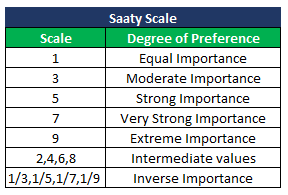

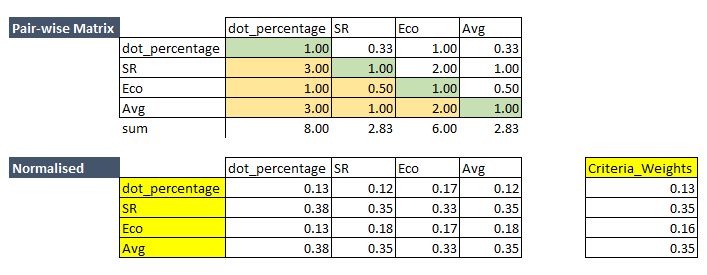

In [92]:
np.mean(df1['Eco']), np.mean(df2['Eco']), np.mean(df3['Eco'])

(7.880727610278703, 8.098557438590072, 10.39577571395939)

In [93]:
np.mean(df1['dot%']), np.mean(df2['dot%']), np.mean(df3['dot%'])

(43.52129824368557, 30.202226418384537, 27.222467690254046)

In [94]:
np.mean(df1['SR']), np.mean(df2['SR']), np.mean(df3['SR'])

(18.789244663382593, 19.814663643235072, 11.030187777590374)

In [95]:
np.mean(df1['Avg']), np.mean(df2['Avg']), np.mean(df3['Avg'])

(23.60303776683087, 27.342419617419615, 19.353547534716366)

In [96]:
# scaling techniques:

# normalization - [0, 1] - ex: Eco (1, 8) => [0, 1]
# standardization - (mean = 0, std = 1) Zscore = (x-m)/s

In [98]:
# norm:
# max_val
# min_val
# x

# minmax(x) = (x - min_val)/(max_val - min_val) => x == max_val (1), x == min_val (0)

In [99]:
ls1 = [0, 2, 6, 7, 15]

In [100]:
min_val = min(ls1)
max_val = max(ls1)

ls2 = [(x-min_val)/(max_val - min_val) for x in ls1]

In [101]:
ls2

[0.0, 0.13333333333333333, 0.4, 0.4666666666666667, 1.0]

In [102]:
df1 = df1[df1.balls >= 25]

In [103]:
max_val = max(df1['dot%'])
min_val = min(df1['dot%'])

df1['mx_dot%'] = df1['dot%'].apply(lambda x: (x-min_val)/(max_val - min_val))

In [104]:
max_val = max(df1['Eco'])
min_val = min(df1['Eco'])

df1['mx_Eco'] = df1['Eco'].apply(lambda x: (x-min_val)/(max_val - min_val))

In [105]:
max_val = max(df1['SR'])
min_val = min(df1['SR'])

df1['mx_SR'] = df1['SR'].apply(lambda x: (x-min_val)/(max_val - min_val))

In [106]:
max_val = max(df1['Avg'])
min_val = min(df1['Avg'])

df1['mx_Avg'] = df1['Avg'].apply(lambda x: (x-min_val)/(max_val - min_val))

In [108]:
df1['minmax_score'] = df1.apply(lambda x: x['mx_dot%']*0.13 + x['mx_Eco']*0.16 + x['mx_SR']*0.35 + x['mx_Avg']*0.35, axis = 1)

In [112]:
df1.sort_values('minmax_score', ascending = True).head(10)

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,Eco,Avg,mx_dot%,mx_Eco,mx_SR,mx_Avg,minmax_score
63,JJ Bumrah,4,34,22,3,22,64.705882,11.333333,3.882353,7.333333,0.754230,0.039216,0.018476,0.001083,0.111170
126,SP Narine,6,36,24,2,22,61.111111,18.000000,4.000000,12.000000,0.680365,0.055556,0.053910,0.027620,0.125872
42,DS Kulkarni,4,55,50,7,33,60.000000,7.857143,5.454545,7.142857,0.657534,0.257576,0.000000,0.000000,0.126692
62,JH Kallis,12,100,105,6,44,44.000000,16.666667,6.300000,17.500000,0.328767,0.375000,0.046824,0.058895,0.139741
60,JDP Oram,2,27,22,0,13,48.148148,27.000000,4.888889,22.000000,0.414003,0.179012,0.101746,0.084484,0.147643
8,AB Dinda,8,109,113,5,44,40.366972,21.800000,6.220183,22.600000,0.254116,0.363914,0.074108,0.087896,0.147963
39,DL Vettori,4,30,35,2,13,43.333333,15.000000,7.000000,17.500000,0.315068,0.472222,0.037965,0.058895,0.150416
117,S Sreesanth,3,42,35,2,24,57.142857,21.000000,5.000000,17.500000,0.598826,0.194444,0.069856,0.058895,0.154021
3,A Mithun,3,25,30,0,7,28.000000,25.000000,7.200000,30.000000,0.000000,0.500000,0.091116,0.129976,0.157382
111,S Aravind,19,248,273,14,116,46.774194,17.714286,6.604839,19.500000,0.385771,0.417339,0.052392,0.070268,0.159855


In [113]:
mean_val = np.mean(df1['Eco'])
std_val = np.std(df1['Eco'])

df1['z_Eco'] = df1['Eco'].apply(lambda x: (x - mean_val)/std_val)

In [114]:
df1.head(1)

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,Eco,Avg,mx_dot%,mx_Eco,mx_SR,mx_Avg,minmax_score,z_Eco
3,A Mithun,3,25,30,0,7,28.0,25.0,7.2,30.0,0.0,0.5,0.091116,0.129976,0.157382,0.031719


### Topsis Method:

In [115]:
wt_sr, wt_dot, wt_eco, wt_avg = 0.35, 0.13, 0.16, 0.35

### Calculation - Normalizing all values to same dimensions

In [116]:
df1['calc_SR'] = df1['SR'].apply(lambda x: x*x) 
df1['calc_dot%'] = df1['dot%'].apply(lambda x: x*x) 
df1['calc_Eco'] = df1['Eco'].apply(lambda x: x*x) 
df1['calc_Avg'] = df1['Avg'].apply(lambda x: x*x)

sq_sr, sq_dot, sq_Eco, sq_Avg = np.sqrt(df1[['calc_SR','calc_dot%', 'calc_Eco', 'calc_Avg']].sum(axis = 0))

df1['calc_SR'] = df1['calc_SR'].apply(lambda x: x/sq_sr) 
df1['calc_dot%'] = df1['calc_dot%'].apply(lambda x: x/sq_dot) 
df1['calc_Eco'] = df1['calc_Eco'].apply(lambda x: x/sq_Eco) 
df1['calc_Avg'] = df1['calc_Avg'].apply(lambda x: x/sq_Avg)

df1['calc_SR'] = df1['calc_SR'].apply(lambda x: x*wt_sr) 
df1['calc_dot%'] = df1['calc_dot%'].apply(lambda x: x*wt_dot) 
df1['calc_Eco'] = df1['calc_Eco'].apply(lambda x: x*wt_eco) 
df1['calc_Avg'] = df1['calc_Avg'].apply(lambda x: x*wt_avg)

best_sr, worst_sr = min(df1['calc_SR']), max(df1['calc_SR'])
best_dot, worst_dot = min(df1['calc_dot%']), max(df1['calc_dot%'])
best_Eco, worst_Eco = min(df1['calc_Eco']), max(df1['calc_Eco'])
best_Avg, worst_Avg = min(df1['calc_Avg']), max(df1['calc_Avg'])

###  Calculation - Comparision against the best & worst values

In [117]:
df1['dev_best_SR'] = df1['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
df1['dev_best_dot%'] = df1['calc_dot%'].apply(lambda x: (x-best_dot)*(x-best_dot)) 
df1['dev_best_Eco'] = df1['calc_Eco'].apply(lambda x: (x-best_Eco)*(x-best_Eco)) 
df1['dev_best_Avg'] = df1['calc_Avg'].apply(lambda x: (x-best_Avg)*(x-best_Avg))

df1['dev_best_sqrt'] = df1.apply(lambda x: x['dev_best_SR'] + x['dev_best_dot%'] + x['dev_best_Eco'] + x['dev_best_Avg'], axis = 1) 

df1['dev_worst_SR'] = df1['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
df1['dev_worst_dot%'] = df1['calc_dot%'].apply(lambda x: (x-worst_dot)*(x-worst_dot)) 
df1['dev_worst_Eco'] = df1['calc_Eco'].apply(lambda x: (x-worst_Eco)*(x-worst_Eco)) 
df1['dev_worst_Avg'] = df1['calc_Avg'].apply(lambda x: (x-worst_Avg)*(x-worst_Avg))

df1['dev_worst_sqrt'] = df1.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_dot%'] + x['dev_worst_Eco'] + x['dev_worst_Avg'], axis = 1) 

### Final Step - Overall score for each player ( values from 0 - 1)

In [118]:
df1['topsis_score'] = df1.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)